In [1]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
from xgboost import XGBRegressor
import plotly.express as px
from pathlib import Path
import pandas as pd
import numpy as np
import holidays
import warnings

warnings.filterwarnings('ignore')

In [2]:
def upload_data():
    data_path = str(Path.cwd().parent) + "\\Data\\EPC\\Power Consumption Data.csv"
    
    df = pd.read_csv(data_path)
    
    df = df[df["real_consumption"] > 0]
    df = df[df['real_consumption'] <= df['real_consumption'].mean() + 4 * df['real_consumption'].std()]
    
    df['time'] = pd.to_datetime(df['time'])
    df = df.sort_values(by='time',ascending=True)
    
    return df

def data_metrics(data, real, predicted):

    y_true = data[real]
    y_pred = data[predicted]

    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)


    # MAE (Mean Absolute Error):
    # Lower values are better; good MAE depends on the scale of 'real_consumption'.
    # As a rule of thumb, MAE should be significantly smaller than the mean of the target variable.
    # Lower is better. Ideally, MAE should be much less than the average value of y_true.
    print(f"MAE: {mae:.4f}")

    # MSE (Mean Squared Error):
    # Similar to MAE but penalizes large errors more heavily. A smaller MSE is better.
    # Compare MSE to the variance of 'real_consumption' for context.
    # Lower is better. MSE should ideally be close to zero relative to the variance of y_true.
    print(f"MSE: {mse:.4f}")



    # RMSE (Root Mean Squared Error):
    # RMSE is the square root of MSE and is in the same units as 'real_consumption'.
    # A good RMSE is often close to the standard deviation of 'real_consumption'.
    # Lower is better. RMSE should be comparable to or less than the standard deviation of y_true."
    print(f"RMSE: {rmse:.4f}")



    # R² (Coefficient of Determination):
    # R² measures how well the predictions explain the variability of the data.
    # Values close to 1.0 are excellent, indicating the model explains most of the variance.
    # Negative values indicate poor fit.
    # Closer to 1.0 is better. Values > 0.7 are generally good; < 0.5 indicates underfitting.
    print(f"R²: {r2:.4f}")

def feature_engineering(data):

    # Extracting basic time-based features
    data['hour'] = data['time'].dt.hour  # Hour of the day
    data['minute'] = data['time'].dt.minute  # Minute
    data['day_of_week'] = data['time'].dt.dayofweek  # Day of the week (0=Monday, 6=Sunday)
    data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)  # Weekend flag
    data['day_of_month'] = data['time'].dt.day
    data['week_of_year'] = data['time'].dt.isocalendar().week
    data['month'] = data['time'].dt.month
    data['quarter'] = data['time'].dt.quarter
    data['year'] = data['time'].dt.year


    # Generate lag features for temporal dependency modeling
    for lag in range(1, 5):  # Create lag features for the past 4 time steps
        data[f'lag_{lag}'] = data['real_consumption'].shift(lag)


    # Generate exponential moving averages
    for span in [3, 5]:  # Spans of size 3, 5, and 7
        data[f'ema_{span}'] = data['real_consumption'].ewm(span=span, adjust=False).mean()

    # Rolling average over a longer period (e.g., weekly and monthly moving averages)
    data['weekly_avg'] = data['real_consumption'].rolling(window=7*24*20, min_periods=1).mean()  # Weekly moving avg
    data['monthly_avg'] = data['real_consumption'].rolling(window=30*24*20, min_periods=1).mean()  # Monthly moving avg


# Percentage change in real consumption
    data['pct_change'] = data['real_consumption'].pct_change()

    data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)  # Cyclic hour feature (sine)
    data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)  # Cyclic hour feature (cosine)
 
    data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
    data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)
    
    data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
    
    data['week_of_year_sin'] = np.sin(2 * np.pi * data['week_of_year'] / 52)
    data['week_of_year_cos'] = np.cos(2 * np.pi * data['week_of_year'] / 52)




    # Get Georgia holidays for all years in the dataset
    georgia_holidays = holidays.Georgia(years=range(data["year"].min(), data["year"].max() + 1))

    data["date"] = data["time"].dt.date
    
    # Create holiday feature (1 if it's a holiday, 0 otherwise)
    data['is_holiday'] = data["date"].map(lambda x: 1 if x in georgia_holidays else 0)
    
    # Add features for the day before and after a holiday
    data['is_day_before_holiday'] = data["date"].map(lambda x: 1 if (x - pd.Timedelta(days=1)) in georgia_holidays else 0)
    data['is_day_after_holiday'] = data["date"].map(lambda x: 1 if (x + pd.Timedelta(days=1)) in georgia_holidays else 0)



    return  data



In [3]:
df = upload_data()

data_metrics(data=df, real="real_consumption", predicted="predicted_consumption")

df = feature_engineering(df)


MAE: 56.7256
MSE: 5824.3342
RMSE: 76.3173
R²: 0.9176


In [4]:
last_5_months_start = df['time'].max() - pd.DateOffset(months=5)
test_mask = df['time'] >= last_5_months_start

last_5_months_df = df[test_mask]
df = df[~test_mask]



In [9]:
# df.head(10)
df.columns

Index(['time', 'real_consumption', 'predicted_consumption', 'hour', 'minute',
       'day_of_week', 'is_weekend', 'day_of_month', 'week_of_year', 'month',
       'quarter', 'year', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'ema_3', 'ema_5',
       'weekly_avg', 'monthly_avg', 'pct_change', 'hour_sin', 'hour_cos',
       'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
       'week_of_year_sin', 'week_of_year_cos', 'date', 'is_holiday',
       'is_day_before_holiday', 'is_day_after_holiday'],
      dtype='object')

In [28]:
dftest = df[["real_consumption",
             "predicted_consumption",
             "hour",
             "weekly_avg",
             "monthly_avg",
             "week_of_year",
             "month",
             "hour_sin",
             "hour_cos",
             "lag_1",
             "lag_2",
             "lag_3",
             "lag_4",
             "ema_3",
             "ema_5",
             "month_sin",
             "month_cos",
             "week_of_year_sin",
             "week_of_year_cos"]]


dftest2 = df.drop(columns=["date","time",
                           "predicted_consumption",
                           "hour",
                           "weekly_avg",
                           "monthly_avg",
                           "week_of_year",
                           "month",
                           "hour_sin",
                           "hour_cos",
                           "lag_1",
                           "lag_2",
                           "lag_3",
                           "lag_4",
                           "ema_3",
                           "ema_5",
                           "month_sin",
                           "month_cos",
                           "week_of_year_sin",
                           "week_of_year_cos"])



dftest_reduced =df[[
            "real_consumption",
            "predicted_consumption",
            "hour",
            "weekly_avg",
            "monthly_avg",
            "hour_sin",
            "hour_cos",
            "lag_1",
            "ema_3",
            "ema_5",
            "month_sin",
            "month_cos",
            "week_of_year_sin",
            "week_of_year_cos"]]

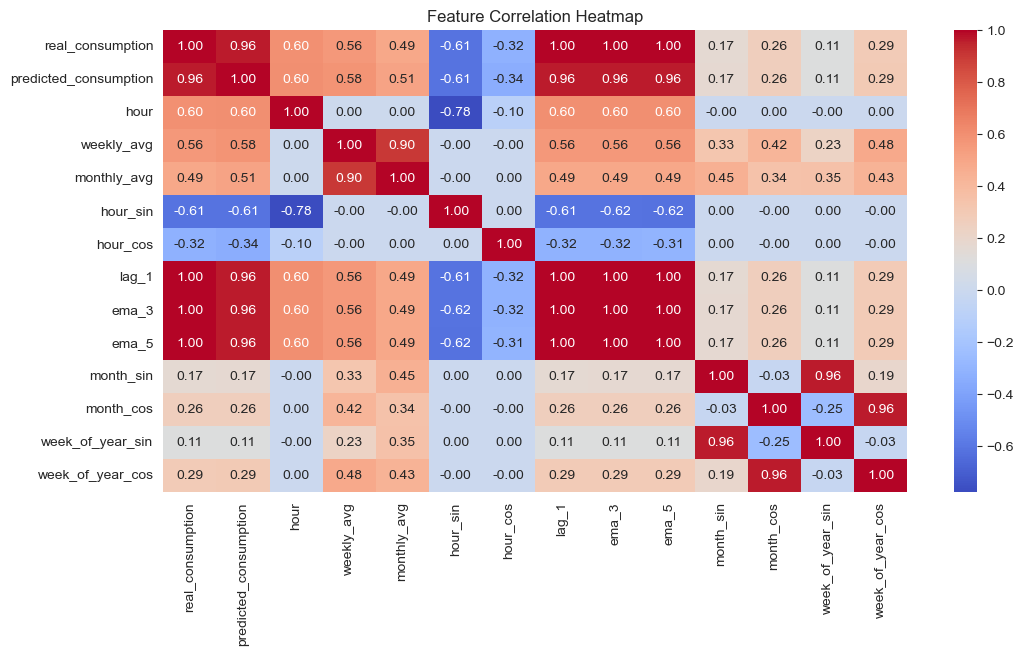

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = dftest_reduced.corr()

# Plot heatmap
plt.figure(figsize=(12,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()



In [84]:
df = df[["time","real_consumption","predicted_consumption","hour","weekly_avg","monthly_avg","hour_sin",
         "hour_cos","lag_1","ema_3","month_sin","month_cos","week_of_year_sin","week_of_year_cos"]]

# Step 2: Separate features (X) and target variable (y)
X = df.drop(columns=[ 'time', 'real_consumption', 'predicted_consumption',"ema_3"])  # Features
y = df['real_consumption']  # Target variable


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42,shuffle=True)

In [74]:
# Define the model
model = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=100, max_depth=6, learning_rate=0.1,subsample=0.8,colsample_bytree=1.0,min_child_weight=5,gamma=0,reg_alpha=0.1,reg_lambda=10)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100],
    'max_depth': [6],
    'learning_rate': [0.1],
    'subsample': [0.8],
    'colsample_bytree': [1.0],
    'min_child_weight': [5],
    'gamma': [0],
    'reg_alpha': [0.1],
    'reg_lambda': [10]
}

# Grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


KeyboardInterrupt: 

In [85]:
# Initialize the model
model = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=100, max_depth=6, learning_rate=0.1,subsample=0.8,colsample_bytree=1.0,min_child_weight=5,gamma=0,reg_alpha=0.1,reg_lambda=10)
# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate the model
train_rmse_xgb = mean_squared_error(y_train, y_pred_train, squared=False)
test_rmse_xgb = mean_squared_error(y_test, y_pred_test, squared=False)
train_r2_xgb = r2_score(y_train, y_pred_train)
test_r2_xgb = r2_score(y_test, y_pred_test)

print(f"XGBoost - Train RMSE: {train_rmse_xgb:.2f}, Test RMSE: {test_rmse_xgb:.2f}")
print(f"XGBoost - Train R²: {train_r2_xgb:.2f}, Test R²: {test_r2_xgb:.2f}")


XGBoost - Train RMSE: 16.37, Test RMSE: 16.74
XGBoost - Train R²: 1.00, Test R²: 1.00


In [86]:
temp_df = last_5_months_df.head(9)[["time","real_consumption"]]

In [87]:
for i in range(1):  # Adding 3 extra rows
    extra_rows = []
    
    start_time = temp_df["time"].iloc[-1] + timedelta(minutes=3)
    
    extra_rows.append((start_time + timedelta(minutes=3 * i), None))

    # Create a DataFrame for the extra rows
    extra_df = pd.DataFrame(extra_rows, columns=["time", "real_consumption"])
    
    # Combine the original and extra DataFrames
    temp_df = pd.concat([temp_df, extra_df], ignore_index=True)


temp_df

,time,real_consumption
0,2024-06-22 18:54:00,1776.203125
1,2024-06-22 18:57:00,1762.210449
2,2024-06-22 19:00:00,1762.830566
3,2024-06-22 19:03:00,1758.603516
4,2024-06-22 19:06:00,1764.305908
5,2024-06-22 19:09:00,1800.765503
6,2024-06-22 19:12:00,1780.111450
7,2024-06-22 19:15:00,1783.973999
8,2024-06-22 19:18:00,1779.342896
9,2024-06-22 19:21:00,NaN


In [112]:
temp_df

,time,real_consumption
0,2024-06-22 18:54:00,1776.203125
1,2024-06-22 18:57:00,1762.210449
2,2024-06-22 19:00:00,1762.830566
3,2024-06-22 19:03:00,1758.603516
4,2024-06-22 19:06:00,1764.305908
...,...,...
1203,2024-06-25 07:03:00,1319.746948
1204,2024-06-25 07:06:00,1323.898193
1205,2024-06-25 07:09:00,1327.572388
1206,2024-06-25 07:12:00,1331.647461


In [108]:
temp_df = last_5_months_df.head(9)[["time","real_consumption"]]

for i in range(1,1200):
    
    
    for i in range(1):  # Adding 3 extra rows
        extra_rows = []

    start_time = temp_df["time"].iloc[-1] + timedelta(minutes=3)

    extra_rows.append((start_time + timedelta(minutes=3 * i), None))

    # Create a DataFrame for the extra rows
    extra_df = pd.DataFrame(extra_rows, columns=["time", "real_consumption"])

    # Combine the original and extra DataFrames
    temp_df = pd.concat([temp_df, extra_df], ignore_index=True)
    
    
    
    
    
    
    to_predict = feature_engineering(temp_df.copy())[["time","real_consumption","hour","weekly_avg","monthly_avg","hour_sin","hour_cos","lag_1","ema_3","month_sin","month_cos","week_of_year_sin","week_of_year_cos"]].tail(1)
    to_predict_1 = to_predict.drop(columns=['real_consumption','time','ema_3'])  # Features
    # to_predict_1["ema_5"] = to_predict_1["ema_5"]
    prediction = model.predict(to_predict_1)
    
    results = pd.DataFrame({
        'time' : to_predict["time"],
        'predicted_consumption': prediction
    })
    
    
    temp_df.loc[temp_df['time'] == results["time"].tail(1).values[0], ['real_consumption']] = [results["predicted_consumption"].tail(1).values[0]]
    
    


In [109]:
reuslts_df = temp_df[9:].rename(columns={"real_consumption":"predicted_consumption_new"}).merge(last_5_months_df[["time","real_consumption","predicted_consumption"]], on="time", how="left").dropna()

In [110]:
# Create an interactive plot using Plotly
fig = px.line(reuslts_df, x='time', y=['real_consumption', 'predicted_consumption','predicted_consumption_new'], title="Interactive Time Series Plot")

# Customize the plot
fig.update_layout(
    xaxis_title="Timestamp",
    yaxis_title="Values",
    legend_title="Legend",
    xaxis_rangeslider_visible=True  # Enables the date slicer
)

# Show the plot
fig.show()

In [111]:
data_metrics(data=reuslts_df, real="real_consumption", predicted="predicted_consumption_new")

data_metrics(data=reuslts_df, real="real_consumption", predicted="predicted_consumption")

MAE: 77.6846
MSE: 10411.6263
RMSE: 102.0374
R²: 0.8385
MAE: 76.4796
MSE: 7793.1279
RMSE: 88.2787
R²: 0.8791
